In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

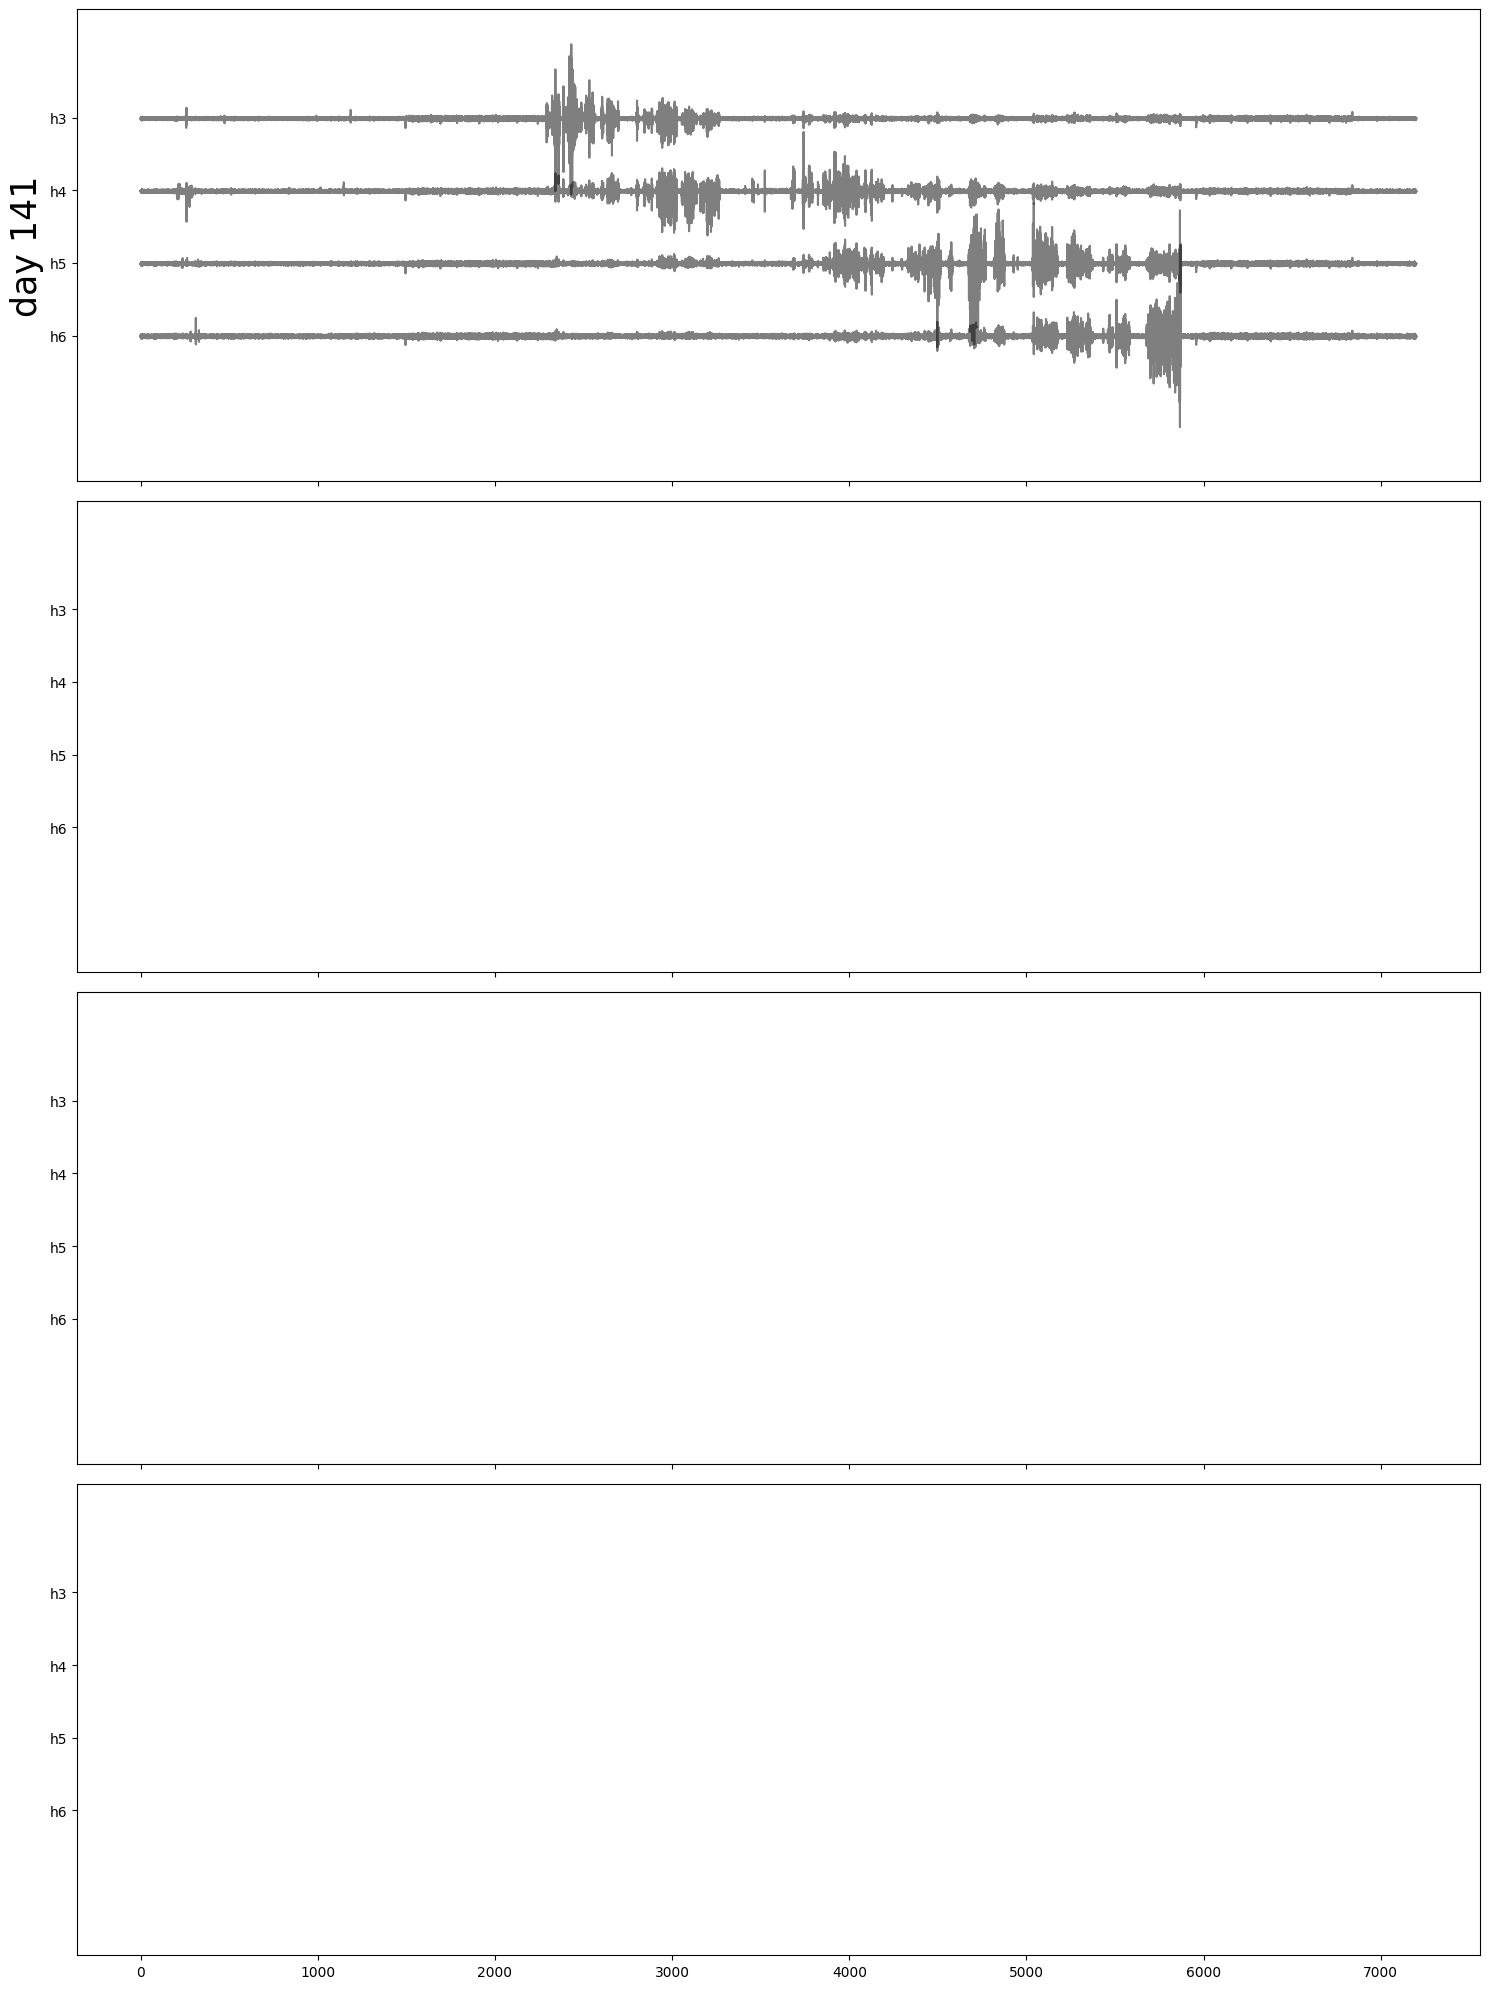

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20), sharey=True, sharex=True)

def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
# plot_waveform(ax=ax[1], stream=day188, day=188)
# plot_waveform(ax=ax[2], stream=day197, day=197)
# plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'])

plt.tight_layout()

# fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

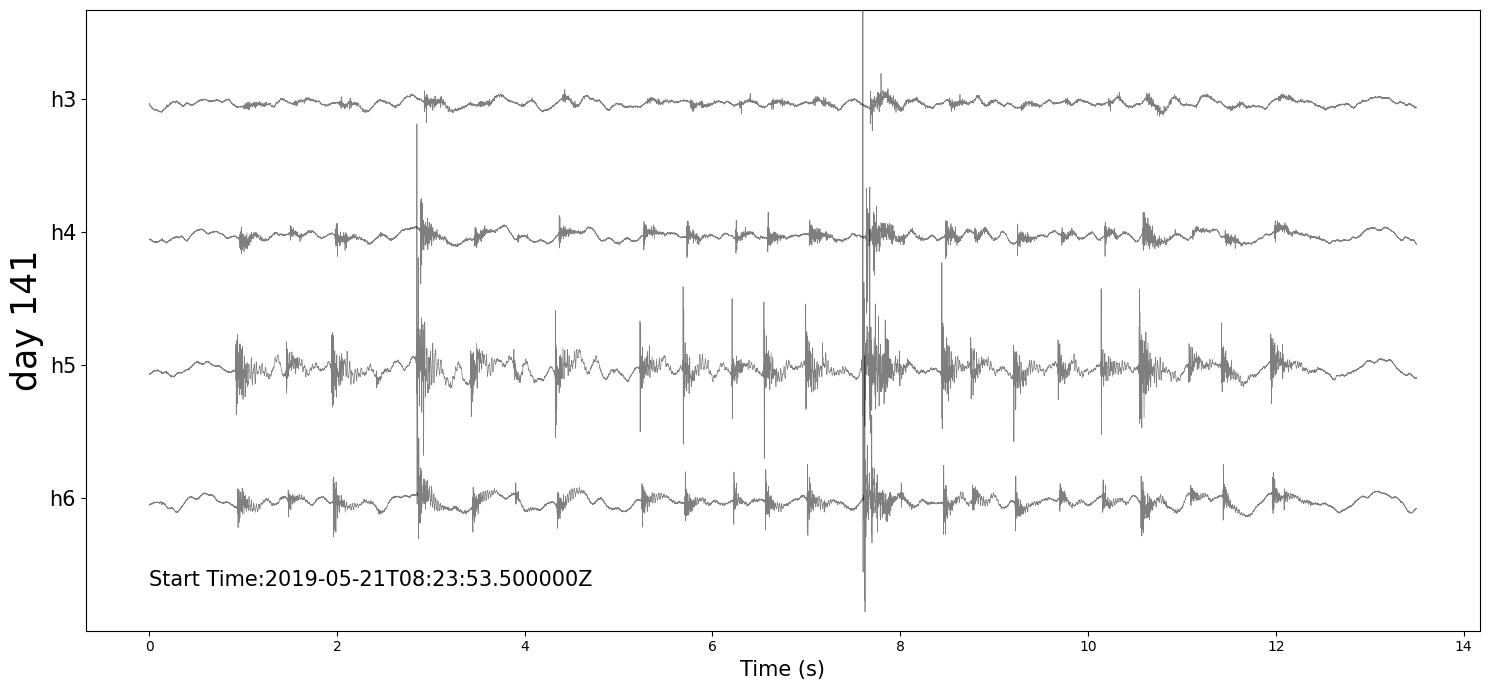

In [6]:
def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 3, color='black', linewidth=0.5, alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

fig, ax = plt.subplots(figsize=(15, 7))
starttime = obspy.UTCDateTime('2019-05-21T08:23:53.500000Z')
endtime = obspy.UTCDateTime('2019-05-21T08:24:07.000000Z')
plot_waveform(ax=ax, stream=day141.copy().trim(starttime, endtime), day=141)
ax.set_ylim(-12, 2)
ax.set_yticks(np.array([0, -1, -2, -3])*3)
ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.text(s=f'Start Time:{starttime}', x=0, y=-11, fontsize=15)
fig.tight_layout()
# fig.savefig('figures/zoom_swarm.pdf', bbox_inches='tight')

In [7]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    return fig, ax

In [9]:
df141 = import_catalog(file='141precision.csv')


In [10]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime']

df141 = df141[columns_to_keep].copy()
# df188 = df188[columns_to_keep].copy()
# df197 = df197[columns_to_keep].copy()
# df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
# df188.sort_values(by='arrival_datetime', inplace=True)
# df197.sort_values(by='arrival_datetime', inplace=True)
# df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
# df188 = df188[df188.max_amp > 0.1].copy()
# df197 = df197[df197.max_amp > 0.1].copy()
# df211 = df211[df211.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [12]:
print('length of day 141 swarm in seconds:', pd.Timedelta(np.array(df141.arrival_datetime.tail(1).values - df141['arrival_datetime'].head(1).values)[0]).total_seconds())

length of day 141 swarm in seconds: 3545.596


In [13]:
print('day141 N-events:', df141.shape)
# print('day188 N-events:', df188.shape)
# print('day197 N-events:', df197.shape)
# print('day211 N-events:', df211.shape)

day141 N-events: (1931, 12)


In [14]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
# print('Day 188 event length:', get_swarm_time_length(df188))
# print('Day 197 event length:', get_swarm_time_length(df197))
# print('Day 211 event length:', get_swarm_time_length(df211))

Day 141 event length: 3545.596


In [29]:
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

def get_event(event_id, day_number, df):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
             )
    return e

def plot_spectrogram(event, hydrophone_index, ax):
    trace = event.stream[hydrophone_index]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.spectrogram(n_fft=32)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')
    

def plot_50hz_highpass(event, hydrophone_index, ax):
    trace = event.stream[hydrophone_index]
    t_labels = trace.times() * 1e3
    times = trace.times('matplotlib')
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)
    ax.set_xticks(times[::50])
    ax.set_xticklabels(t_labels[::50])

def plot_aic_pick(event, hydrophone_index, ax):
    aic_time = event.aic_t[hydrophone_index]
    ax.vlines(x=aic_time, ymin=-0.9, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_aic(event, hydrophone_index, ax):
    times = event.stream[hydrophone_index].times('matplotlib')
    AICs = event.aics[hydrophone_index]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, hydrophone_index, ax):
    times = event.stream[hydrophone_index].times('matplotlib')
    AICs = event.aics[hydrophone_index]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
    plot_50hz_highpass(event=e, hydrophone_index=4, ax=ax[0])
    plot_aic_pick(event=e, hydrophone_index=4, ax=ax[0])
    plot_aic(event=e, hydrophone_index=4, ax=ax[1])
    ax2 = ax[1].twinx()
    plot_aic_diff(event=e, hydrophone_index=4, ax=ax2)
    plot_spectrogram(event=e, hydrophone_index=4, ax=ax[2])
    fig.tight_layout()

/Users/mnky9800n/repos/boreholeCrack/event_pipeline.py:202: RuntimeWarning: invalid value encountered in sqrt
  self.radius =  np.sqrt(vrock**2 * dt**2 - dz**2)


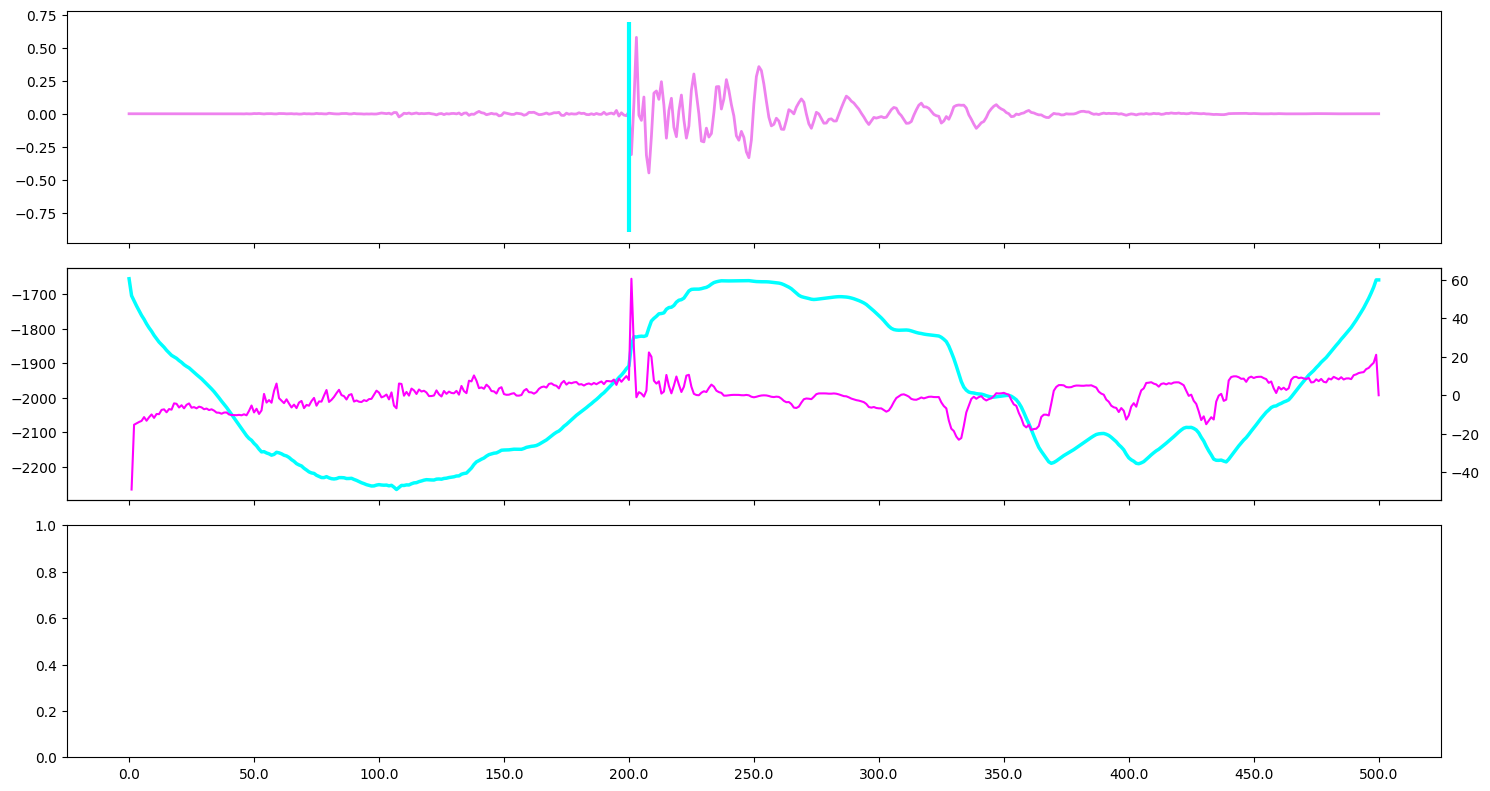

In [30]:
plot_event(event_id=1058, day_number=141, df=df141)